In [3]:
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

import numpy as np
from typing import Union
import math

sys.path.append('..')
from lib.model_utils import ModelUtil, export_rules_to_csv
utils = ModelUtil(data_name = 'german', model_name = 'random forest')

Test
Accuracy Score is 0.828
Precision Score is 0.8663101604278075
F1 Score is 0.88283378746594
Train
Accuracy Score is 0.8932692307692308


In [8]:
mat = utils.get_cover_matrix(utils.X, fuzzy = True)

In [10]:
mat0 = utils.get_cover_matrix(utils.X, fuzzy = False)

In [11]:
def run_loci(data: np.ndarray, alpha: float = 0.5, k: int = 3):
    """Run the LOCI algorithm on the specified dataset.
    Runs the LOCI algorithm for the specified datset with the specified
    parameters, returns a LOCI object, from which outlier indices can
    be accessed via the indice property.
    Parameters
    ----------
    data: np.ndarray
        Shape - [number of datapoints, number of dimensions]
    alpha: float, optional
        Default is 0.5 as per the paper. See the paper for full details.
    k: int, optional
        Default is 3 as per the paper. See the paper for full details.
    """
    loci_i = LOCIMatrix(data, alpha, k)
    loci_i.run()
    return loci_i



class LOCIMatrix():
    """
    data: np.ndarray
    alpha: float, optional
    k: int, optional
    See the loci function for more details on the parameters.
    Attributes
    ----------
    _data: np.ndarray
    _alpha: float
    _k: int
    max_dist: float
    n_points: int
    indice: np.ndarray
    _dist_matrix: np.ndarray
        The distance matrix, has shape [n_data_points, n_data_points]
    """

    def __init__(self, data: np.ndarray, alpha: float = 0.5, k: int = 3):
        self.data = data
        self.alpha = alpha
        self.k = k

        self.max_dist = None
        self.n_points = self.data.shape[0]
        self.indice = None
        self.dist_matrix = pairwise_distances(X = self.data, metric='euclidean')
        self.sorted_neighbors = np.argsort(self.dist_matrix, axis=1)
        self.sorted_dist = np.sort(self.dist_matrix, axis=1)
        self.outer_ptr = np.zeros(self.n_points).astype(int)
        self.inner_ptr = np.zeros(self.n_points).astype(int)

    def update_outer_pointer(self, r):
        ptr = self.outer_ptr
        for i in range(self.n_points):
            while ptr[i] < self.n_points and self.sorted_dist[i, ptr[i]] <= r:
                ptr[i] += 1

    def update_inner_pointer(self, r):
        ptr = self.inner_ptr
        for i in range(self.n_points):
            while ptr[i] < self.n_points and self.sorted_dist[i, ptr[i]] <= r:
                ptr[i] += 1

    def run(self):
        """Executes the LOCI algorithm"""
        self.result = []
        for p_ix in range(self.n_points):
            self.result.append({
                'records': [],
            })
        sqrt_n = int(math.sqrt(self.n_points))
        r_max = self.sorted_dist[:, sqrt_n].max() / self.alpha
        r_min = self.sorted_dist[:, 10].min()
        self.rs = []
        self.scores = [[] for _ in range(self.n_points)]
        print('r range: %.3f - %.3f, alpha: %.3f' % (r_min, r_max, self.alpha))

        n_steps = 250
        for i in range(n_steps):
            r = i / n_steps * (r_max - r_min) + r_min
            self.rs.append(r)
            self.update_outer_pointer(r)
            self.update_inner_pointer(self.alpha * r)
            for p_ix in range(self.n_points):
                neighbors = self._get_sampling_N(p_ix)
                n_values = self._get_alpha_n(neighbors)
                cur_alpha_n = self._get_alpha_n(p_ix)

                n_hat = np.mean(n_values)
                mdef = 1 - (cur_alpha_n / n_hat)
                sigma_mdef = np.std(n_values) / n_hat
                self.result[p_ix]['records'].append((r, mdef, sigma_mdef))

                score = 0
                if len(neighbors) >= 20:
                    if sigma_mdef > 0:
                        score = mdef / sigma_mdef
                self.scores[p_ix].append(score)

        step = (r_max - r_min) / n_steps
        r = self.sorted_dist[:, int(math.sqrt(self.n_points))].mean()
        self.indice = np.array([int((self.sorted_dist[i, sqrt_n] - r_min) / step) for i in range(self.n_points)])
        self.min_indice = np.array([np.argmin(self.scores[i]) for i in range(self.n_points)])
        self.max_indice = np.array([np.argmax(self.scores[i]) for i in range(self.n_points)])
        self.scores = np.array(self.scores)
        self.outlier_score = np.array([self.scores[i, self.indice[i]] for i in range(self.n_points)])
        return True

    def label_propagation(self, x, label, thres = 0.10):
        conf = {}
        visit = {}
        conf[x] = 1
        Q = [x]
        head = 0
        while head < len(Q):
            x = Q[head]
            head += 1
            if x in visit:
                continue
            visit[x] = 1
            
            if label == 0:
                new_indice = self.min_indice[x]
            else:
                new_indice = self.max_indice[x]
            self.indice[x] = self.indice[x] * conf[x] + new_indice * (1 - conf[x])
            for i, j in enumerate(self.sorted_neighbors[x]):
                sim = (1 - self.sorted_dist[x, i]) * conf[x]
                if sim < thres:
                    break
                conf[j] = conf.get(j, 0) + sim
                Q.append(j)

    def _get_sampling_N(self, p_ix: int):
        return self.sorted_neighbors[p_ix][:self.outer_ptr[p_ix]]

    def _get_alpha_n(self, indices: Union[int, np.ndarray]):
        return self.inner_ptr[indices]



In [14]:
loci0 = LOCIMatrix(mat0)

In [19]:
print(loci0.sorted_dist[:, 20].mean())
sqrt_n = int(math.sqrt(loci0.n_points))
print(loci0.sorted_dist[:, 100].mean())
alpha0 = loci0.sorted_dist[:, 20].mean() / loci0.sorted_dist[:, 100].mean()
print('alpha0', alpha0)

4.473629660154719
4.7199551487634555
alpha0 0.9478119005700151


In [21]:
loci = LOCIMatrix(mat)

In [23]:
mat_compressed = np.array(mat)
mat_compressed[mat_compressed < 1] *= 0.5

In [24]:
loci_compressed = np.array(mat_compressed)

In [12]:
res0 = run_loci(mat0)

r range: 1.414 - 26.153, alpha: 0.500


In [26]:
res = run_loci(mat)

r range: 1.414 - 29.881, alpha: 0.500


In [70]:
res_e = run_loci(mat)

r range: 1.414 - 29.881, alpha: 0.500


In [27]:
from sklearn.manifold import TSNE
x_tsne = TSNE(n_components=2, metric='precomputed').fit_transform(res.dist_matrix)

/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


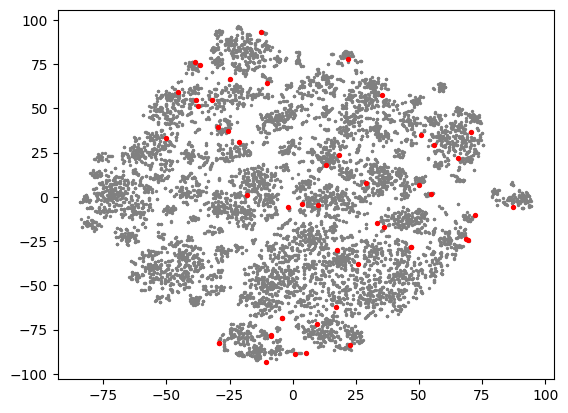

In [60]:
anomaly = res.outlier_score.argsort()[-50:][::-1]
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[anomaly, 0], x_tsne[anomaly, 1], s = 8, color='red')
plt.show()

In [25]:
fig, ax = plt.subplots()
xs = [i for i in range(10, 500, 10)]
ax.plot(xs, res0.sorted_dist[:, xs].mean(axis = 0), label='0-1 coverage')
# ax.plot(xs, res.sorted_dist[:, xs].mean(axis = 0), label='fuzzy coverage')
ax.plot(xs, loci_compressed.sorted_dist[:, xs].mean(axis = 0), label='fuzzy coverage')
ax.set_xlabel('k-neighbors')
ax.set_ylabel('dist')
ax.legend()
plt.show()

NameError: name 'res' is not defined

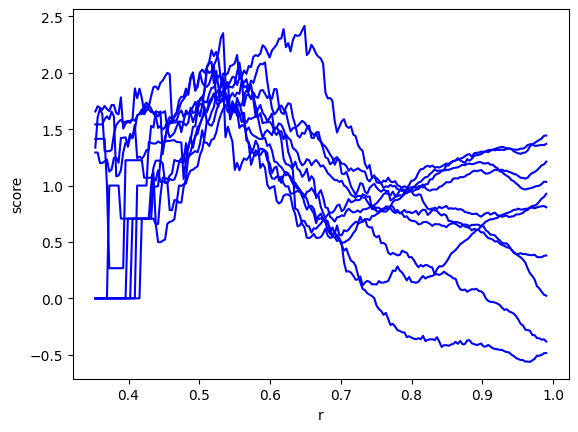

In [48]:
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-10:]
for x in tp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][50:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][50:-5]])
    s_mdefs = np.array([max(y[2], 0.01) for y in res.result[x]['records'][50:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
ax.set_xlabel('r')
ax.set_ylabel('score')
# ax.set_yscale('log')
#  ax.legend()
plt.show()

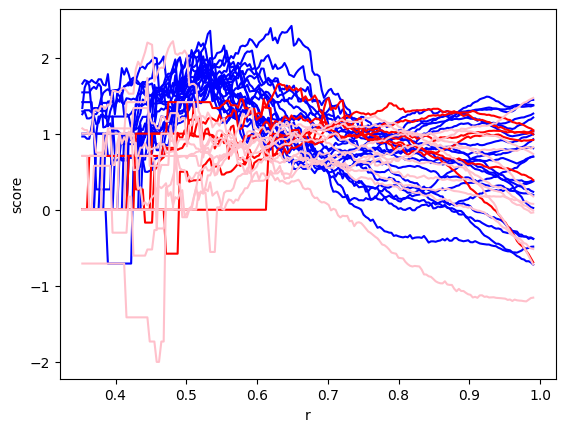

In [44]:
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-20:]
for x in tp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][50:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][50:-5]])
    s_mdefs = np.array([max(y[2], 0.01) for y in res.result[x]['records'][50:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
fp = [8629, 1193, 2732, 5578, 4628, 4234]
for x in fp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][50:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][50:-5]])
    s_mdefs = np.array([max(y[2], 0.01) for y in res.result[x]['records'][50:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='r')
normal = [1,2,3,4,5,6,7,8,9,50]
for x in normal:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][50:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][50:-5]])
    s_mdefs = np.array([max(y[2], 0.01) for y in res.result[x]['records'][50:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='pink')
ax.set_xlabel('r')
ax.set_ylabel('score')
# ax.set_yscale('log')
#  ax.legend()
plt.show()

In [88]:
all_labels = {7305: 1, 8624: 0, 1884: 1, 468: 1, 6290: 0, 8055: 0, 2280: 1, 3400: 1, 4466: 0, 4650: 0, 6028: 1, 4459: 1, 1411: 1, 665: 0, 868: 1, 8911: 1, 3848: 0, 9283: 0, 5218: 0, 3035: 0, 1010: 1, 8934: 1, 6483: 1, 2807: 1, 5767: 1, 1763: 1, 4479: 1, 679: 1, 873: 1, 6641: 1, 178: 0, 2278: 1, 7567: 0, 287: 1, 7527: 1, 6569: 1, 3487: 1, 2363: 1, 1750: 0, 2300: 1, 6277: 0, 8240: 1, 7499: 1, 525: 0, 4785: 0, 9324: 0, 3337: 1, 3617: 1, 5003: 1, 2089: 1, 3204: 1, 991: 1, 2167: 1, 3488: 1, 1507: 1, 1840: 1, 4932: 1, 254: 1, 9096: 1, 5974: 0, 7529: 1, 2764: 1, 9134: 1, 2112: 0, 7845: 0, 8073: 1, 4657: 0, 3270: 1, 5502: 1, 616: 1, 6787: 0, 6801: 1, 3486: 1, 405: 1, 3485: 1, 8092: 1, 1393: 0, 668: 1, 8389: 0, 2277: 1, 8629: 0, 1520: 1, 4104: 1, 712: 0, 6952: 1, 1330: 1, 8415: 1, 6471: 1, 690: 1, 5575: 1, 5590: 0, 5252: 0, 2079: 1, 1940: 0, 3891: 1, 2916: 0, 1939: 1, 6839: 0, 4384: 1, 3628: 1, 2664: 1, 8645: 1, 7572: 1, 736: 0, 2228: 1, 4759: 1, 729: 0, 4980: 1, 2009: 1, 2099: 0, 4995: 0, 7810: 1, 7571: 1, 5459: 1, 2817: 1, 4812: 1, 4983: 0, 6289: 0, 8022: 0, 4647: 1, 3618: 1, 9452: 1, 4978: 1, 4350: 1, 2706: 1, 758: 1, 2500: 0, 1017: 0, 7915: 0, 5237: 1, 1963: 1, 7556: 0, 3451: 1, 4977: 1, 7456: 1, 424: 1, 4867: 1, 2279: 1, 4234: 0, 3313: 1, 1703: 1, 9289: 0, 827: 0, 8258: 1}


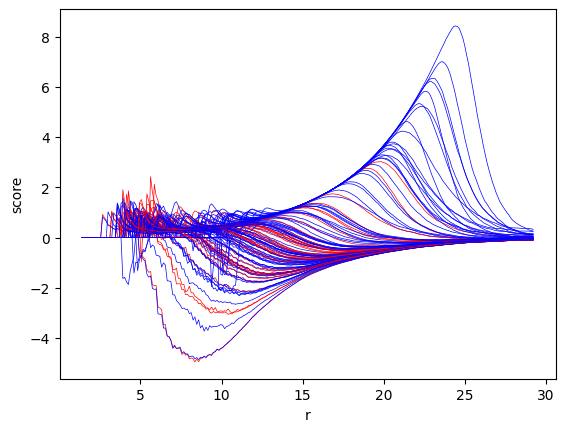

In [89]:
fig, ax = plt.subplots()
fp = [i for i in all_labels if all_labels[i] == 0]
tp = [i for i in all_labels if all_labels[i] == 1]
lines = []

xs = res_e.rs[:-5]
for x in fp:
    lines.append((res_e.scores[x, :-5], 'r', x))
for x in tp:
    lines.append((res_e.scores[x, :-5], 'b', x))

import random
random.shuffle(lines)
for (ys, color, index) in lines:
    ax.plot(xs, ys, color=color, linewidth=0.5)
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

In [86]:
for i in np.argsort([x[0][130] for x in lines])[-10:]:
    print(lines[i][2], all_labels[lines[i][2]])

6569 1
2817 0
4104 1
4384 1
868 1
2664 1
8415 1
6801 1
5459 0
4459 1


In [96]:
res_e.scores[res_e.scores[:, 188].argsort()[-50:], 188]

array([6.56614195, 6.56760611, 6.56760611, 6.5683382 , 6.57053444,
       6.5719986 , 6.57346276, 6.575659  , 6.57712316, 6.57858732,
       6.58005148, 6.58005148, 6.5829798 , 6.5829798 , 6.58590812,
       6.58590812, 6.5866402 , 6.58883644, 6.60054972, 6.60274596,
       6.60347804, 6.60421012, 6.60421012, 6.60421012, 6.6049422 ,
       6.60640636, 6.60640636, 6.60933468, 6.60933468, 6.61079884,
       6.61079884, 6.61153092, 6.612263  , 6.612263  , 6.61299508,
       6.61299508, 6.61445924, 6.61445924, 6.61519132, 6.6159234 ,
       6.61665548, 6.61738756, 6.61738756, 6.61738756, 6.61885172,
       6.61885172, 6.61885172, 6.61885172, 6.62031588, 6.62104796])

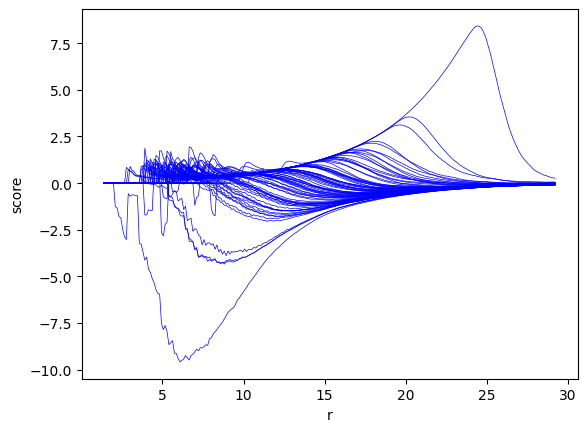

In [93]:
fig, ax = plt.subplots()
lines = []

xs = res_e.rs[:-5]
for x in range(1, 9000, 100):
    lines.append((res_e.scores[x, :-5], 'b', x))

import random
random.shuffle(lines)
for (ys, color, index) in lines:
    ax.plot(xs, ys, color=color, linewidth=0.5)
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

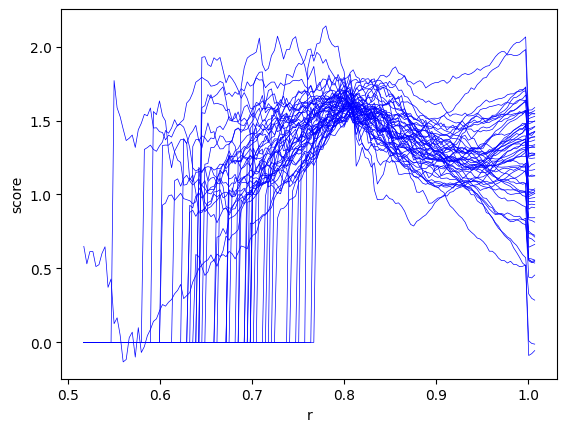

In [62]:

res.outlier_score = res.scores[:, 188]
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-50:]
for x in tp:
    ranks = []
    ax.plot(res.rs[100:], res.scores[x, 100:], linewidth=0.5, color='b')
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

In [63]:
export_rules_to_csv('loci_r600_alpha_0.85', utils, res.outlier_score.argsort()[-50:][::-1])